Reading in data:

In [153]:
import pandas as pd
import numpy as np
data=pd.read_csv('employee_survey.csv')
data.head()

,Ques,group_name,submit_date,review_date,submitted_late,happiness_score
0,employee1,group1,5/24/12 17:11,5/25/12 15:47,0,7.0
1,employee2,group2,5/24/12 17:47,5/25/12 13:49,0,9.0
2,employee3,group2,5/24/12 17:54,5/25/12 13:48,0,7.0
3,employee4,group3,5/24/12 18:13,5/26/12 08:52,0,8910.0
4,employee5,group4,5/24/12 19:04,5/25/12 14:08,0,7.0


Summarizing the happiness score

In [286]:
data.happiness_score.describe()

count    3.861000e+03
mean     2.616567e+05
std      1.625603e+07
min      0.000000e+00
25%      7.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      1.010100e+09
Name: happiness_score, dtype: float64

There seem to be outliers since max value is huge

Number of employees

In [3]:
print(len(data.Ques.unique()))

162


Number of employee groups

In [154]:
print(len(data.group_name.unique()))

43


Number of late / on time submissions

In [155]:
print(len(data[data.submitted_late==1]),len(data[data.submitted_late==0]))

1380 2481


Plotting scores per group 

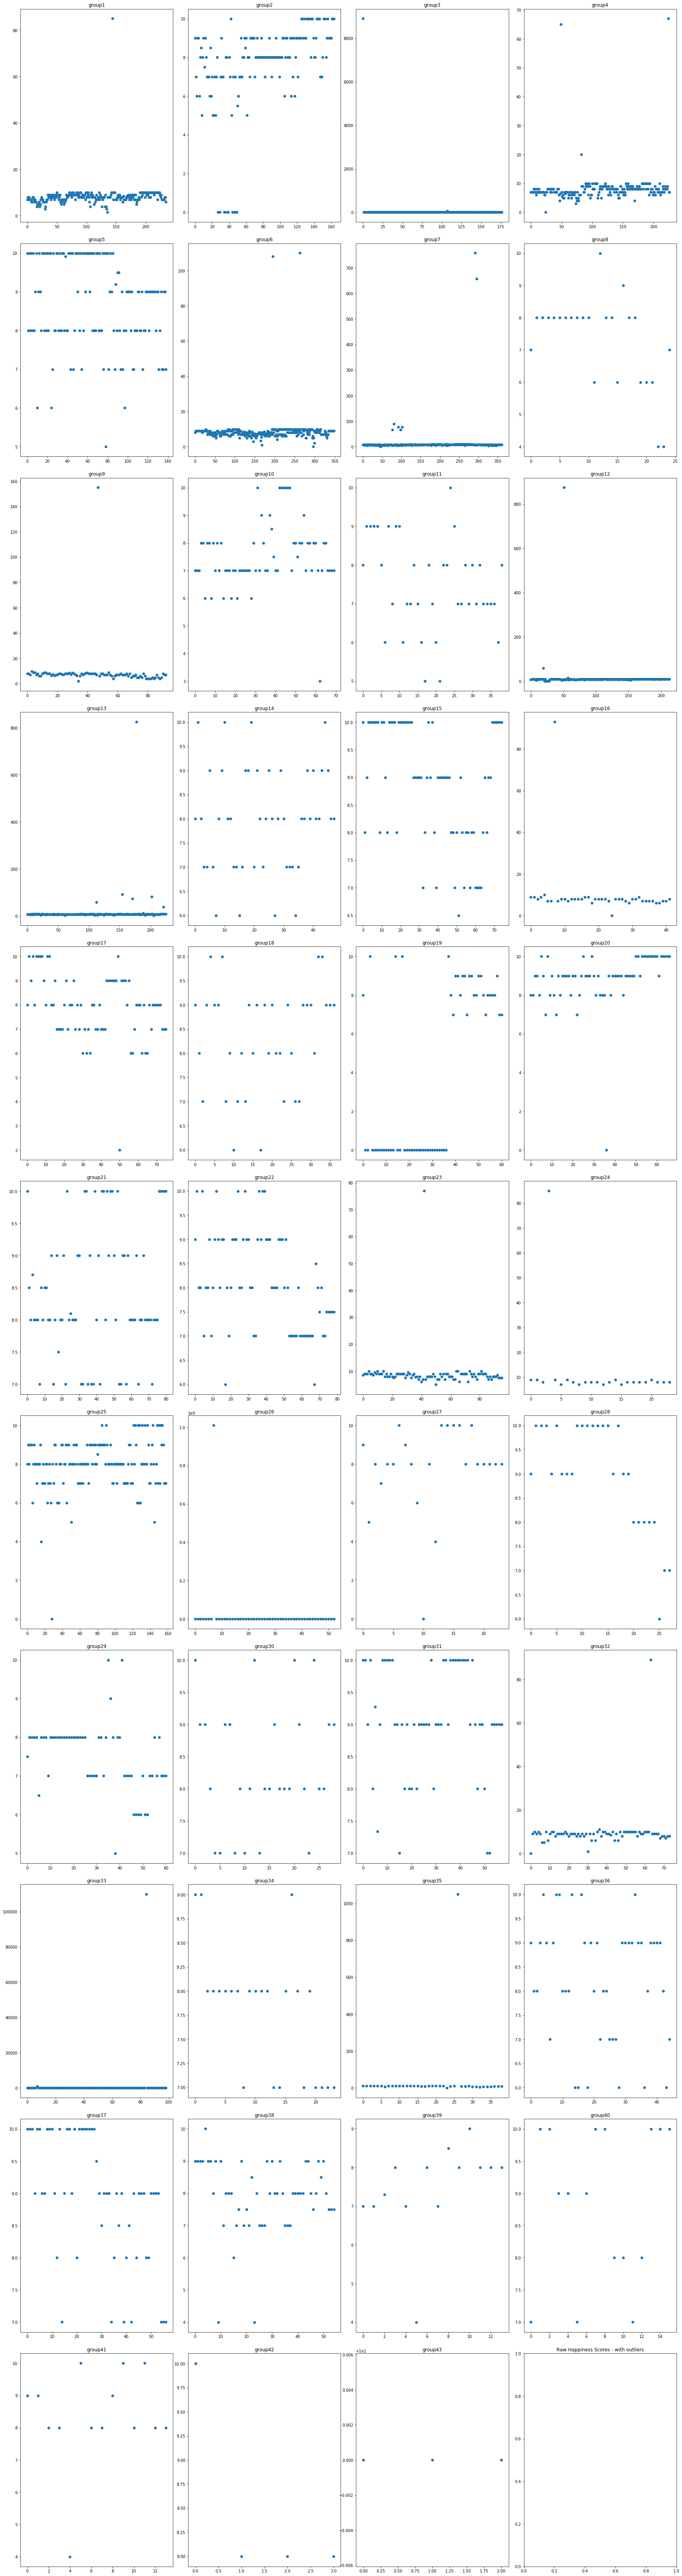

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(11,4, figsize=(30, 120), facecolor='w', edgecolor='k', sharex=False, sharey=False)
fig.subplots_adjust(hspace = .1, wspace=.1)

axs = axs.ravel()

counter=0
for grp in data.group_name.unique():
    axs[counter].scatter(range(len(data[data.group_name==grp].reset_index(drop=True))),data.happiness_score[data.group_name==grp].reset_index(drop=True))
    axs[counter].set_title(grp)
    counter+=1

plt.title('Raw Happiness Scores - with outliers')
plt.show()

There are many outliers in the data. Replacing outliers with group median:


In [7]:
from scipy import stats
medians=data.groupby('group_name')['happiness_score'].agg(lambda x: stats.mode(x)[0][0]).reset_index()
merged_data=pd.merge(left=data, right=medians, left_on='group_name',right_on='group_name', how='left')
merged_data.columns=['employee', 'group', 'submit_date', 'review_date', 'submitted_late','employee_score', 'group_score']
# devs=data.groupby('group_name')['happiness_score'].agg('std').reset_index()
# devs.columns=['group_name', 'sdev']
# # merged_data=pd.merge(left=data, right=medians, left_on='group_name',right_on='group_name', how='left')
# # merged_data.columns=['employee', 'group', 'submit_date', 'review_date', 'submitted_late','employee_score', 'group_score']
# merged_data=pd.merge(left=merged_data, right=devs, left_on='group',right_on='group_name', how='left').drop('group_name', axis=1)
# means=data.groupby('group_name')['happiness_score'].agg('mean').reset_index()
# means.columns=['group_name', 'mean']
# merged_data=pd.merge(left=merged_data, right=means, left_on='group',right_on='group_name', how='left').drop('group_name', axis=1)
merged_data['updated_score']=merged_data.employee_score
for i in range(len(merged_data)):
    if merged_data.at[i,'employee_score']>10:
        merged_data.at[i,'updated_score']=merged_data.at[i,'group_score']



Printing the first 5 rows and summarizing:

In [8]:
print(merged_data.head())
merged_data.updated_score.describe()

    employee   group    submit_date    review_date  submitted_late  \
0  employee1  group1  5/24/12 17:11  5/25/12 15:47               0   
1  employee2  group2  5/24/12 17:47  5/25/12 13:49               0   
2  employee3  group2  5/24/12 17:54  5/25/12 13:48               0   
3  employee4  group3  5/24/12 18:13  5/26/12 08:52               0   
4  employee5  group4  5/24/12 19:04  5/25/12 14:08               0   

   employee_score  group_score  updated_score  
0             7.0          8.0            7.0  
1             9.0          8.0            9.0  
2             7.0          8.0            7.0  
3          8910.0          8.0            8.0  
4             7.0          8.0            7.0  


count    3861.000000
mean        8.028901
std         1.657641
min         0.000000
25%         7.000000
50%         8.000000
75%         9.000000
max        10.000000
Name: updated_score, dtype: float64

All outliers are removed since we replaced the high scores with group median

Plotting updated scores per group

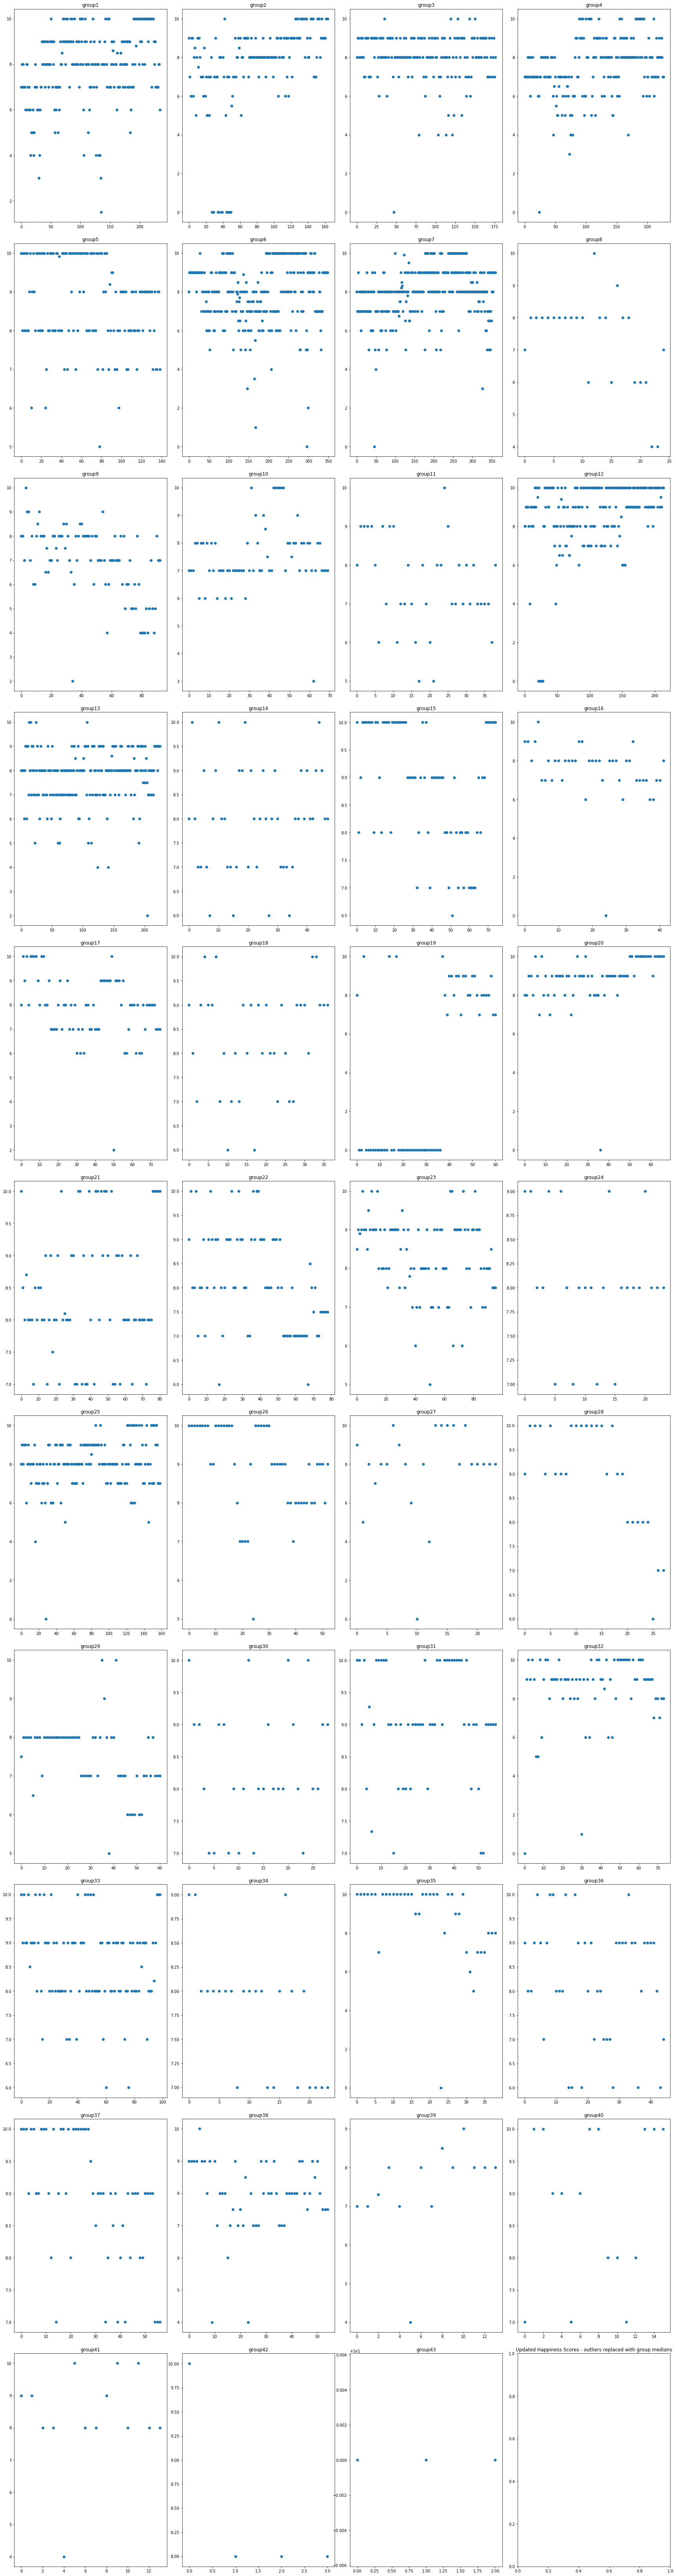

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(11,4, figsize=(30, 120), facecolor='w', edgecolor='k', sharex=False, sharey=False)
fig.subplots_adjust(hspace = .1, wspace=.1)

axs = axs.ravel()

counter=0
for grp in merged_data.group.unique():
    axs[counter].scatter(range(len(merged_data[merged_data.group==grp].reset_index(drop=True))),\
                         merged_data.updated_score[merged_data.group==grp].reset_index(drop=True))
    axs[counter].set_title(grp)
    counter+=1

plt.title('Updated Happiness Scores - outliers replaced with group medians')
plt.show()

Changing time format from string to timestamp 

In [10]:
merged_data.submit_date=data.submit_date.apply(lambda x: pd.Timestamp(x))
#data.review_date=data.review_date.apply(lambda x: pd.Timestamp(x))

Now that we have clean data, we can use this to derive monthly insights on employee happiness:

Creating a month and a day variable with a clean format:

In [157]:
merged_data['month']=merged_data.submit_date.\
apply(lambda x: str(x.year)+"/0"+str(x.month) if len(str(x.month))==1 else str(x.year)+"/"+str(x.month))

merged_data['day']=merged_data.submit_date.\
apply(lambda x: str(x.year)+"/0"+str(x.month)+"/0"+str(x.day) if (len(str(x.month))==1 and len(str(x.day))==1)
      else ( str(x.year)+"/0"+str(x.month)+"/"+str(x.day) if (len(str(x.month))==1 and len(str(x.day))==2 )\
            else str(x.year)+"/"+str(x.month)+"/"+str(x.day)))

Looking at monthly scores per group:

In [158]:
monthly_group=merged_data.groupby(['group', 'month'])['updated_score'].agg('mean').reset_index()
monthly_group.month=monthly_group.month.apply(lambda x: pd.Timestamp(x))
monthly_group.head()

,group,month,updated_score
0,group1,2012-05-01,6.800000
1,group1,2012-06-01,7.704545
2,group1,2012-07-01,8.208333
3,group1,2012-08-01,8.472727
4,group1,2012-09-01,8.376667


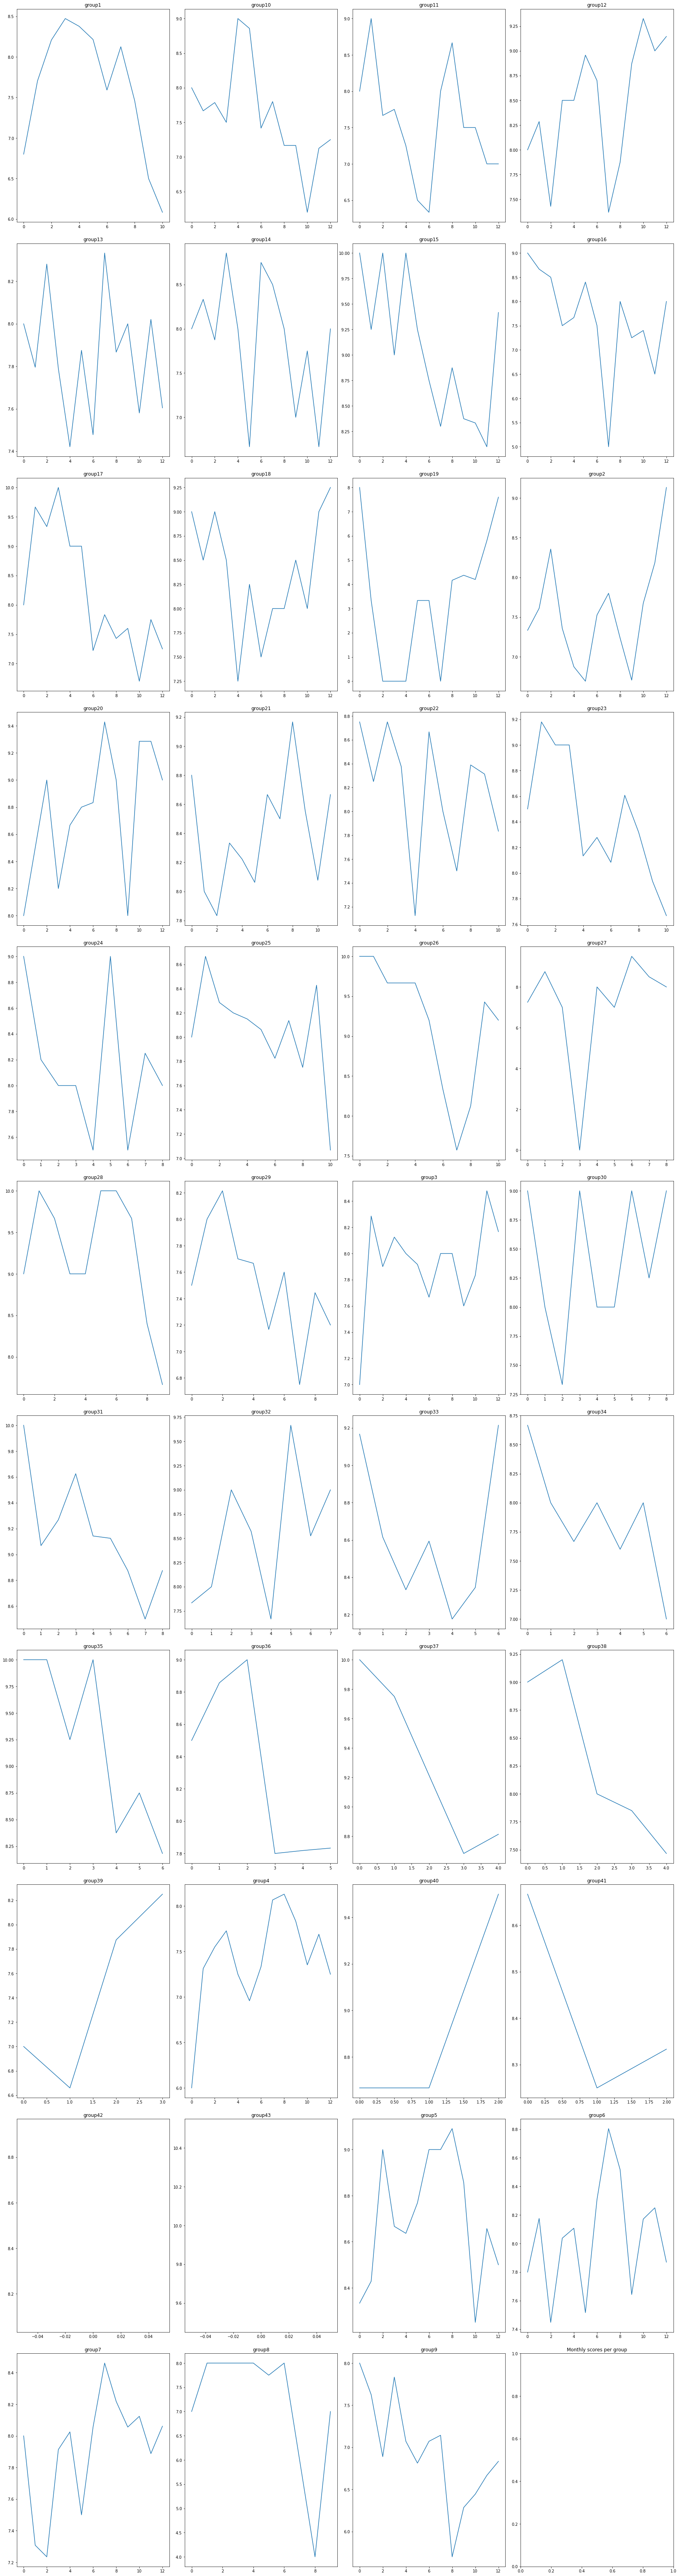

In [162]:
fig, axs = plt.subplots(11,4, figsize=(30, 120), facecolor='w', edgecolor='k', sharex=False, sharey=False)
fig.subplots_adjust(hspace = .1, wspace=.1)

axs = axs.ravel()

counter=0
for grp in monthly_group.group.unique():
    axs[counter].plot(range(len(monthly_group[monthly_group.group==grp].reset_index(drop=True))),\
                         monthly_group.updated_score[monthly_group.group==grp].reset_index(drop=True))
    axs[counter].set_title(grp)
    counter+=1

plt.title('Monthly scores per group')
plt.show()

Overall happiness score increases over months 

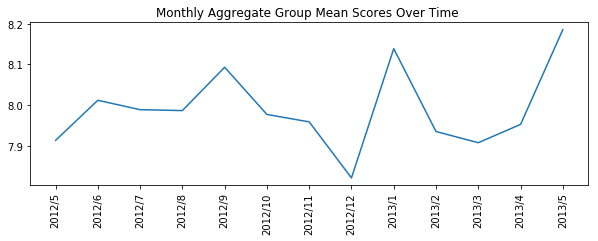

In [287]:
month_means=merged_data.groupby(['month', 'group'])['updated_score'].agg('mean').reset_index()
month_means2=month_means.groupby([ 'month'])['updated_score'].agg('mean').reset_index()
month_means2=month_means2.sort_values(by='month', ascending=True)
plt.figure(figsize=(10,3))
plt.plot (range(len(month_means2.updated_score)),month_means2.updated_score)

plt.xticks(range(len(month_means2.updated_score)),['2012/5', '2012/6', '2012/7', '2012/8', '2012/9', '2012/10',
       '2012/11', '2012/12', '2013/1', '2013/2', '2013/3', '2013/4',
       '2013/5'], rotation='vertical')
plt.title('Monthly Aggregate Group Mean Scores Over Time ')
plt.show()

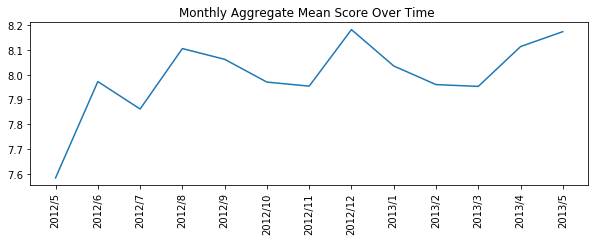

In [163]:
month_means=merged_data.groupby(['month'])['updated_score'].agg('mean').reset_index()
month_means=month_means.sort_values(by='month', ascending=True)
plt.figure(figsize=(10,3))
plt.plot (range(len(month_means.updated_score)),month_means.updated_score)

plt.xticks(range(len(month_means.updated_score)),['2012/5', '2012/6', '2012/7', '2012/8', '2012/9', '2012/10',
       '2012/11', '2012/12', '2013/1', '2013/2', '2013/3', '2013/4',
       '2013/5'], rotation='vertical')
plt.title('Monthly Aggregate Mean Score Over Time ')
plt.show()

But we need to check for late submissions:

Late vs on time submissions per employee averaged:

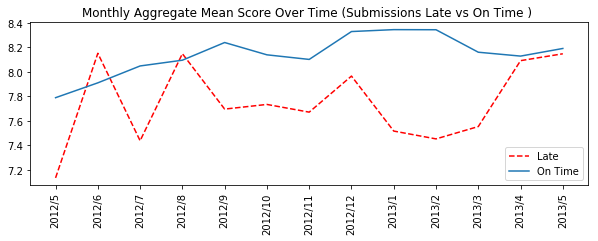

In [164]:
month_means_late=merged_data[merged_data.submitted_late==1].reset_index(drop=True).groupby(['month'])['updated_score'].agg('mean').reset_index()
month_means_late=month_means_late.sort_values(by='month', ascending=True)
month_means_not_late=merged_data[merged_data.submitted_late==0].reset_index(drop=True).groupby(['month'])['updated_score'].agg('mean').reset_index()
month_means_not_late=month_means_not_late.sort_values(by='month', ascending=True)
plt.figure(figsize=(10,3))
plt.plot (range(len(month_means_late.updated_score)),month_means_late.updated_score, color='r', linestyle='dashed')
plt.plot (range(len(month_means_late.updated_score)),month_means_not_late.updated_score)

plt.xticks(range(len(month_means_late.updated_score)),['2012/5', '2012/6', '2012/7', '2012/8', '2012/9', '2012/10',
       '2012/11', '2012/12', '2013/1', '2013/2', '2013/3', '2013/4',
       '2013/5'], rotation='vertical')
plt.title('Monthly Aggregate Mean Score Over Time (Submissions Late vs On Time ) ')
plt.legend(['Late', 'On Time'])
plt.show()

Late vs on time submissions group means:

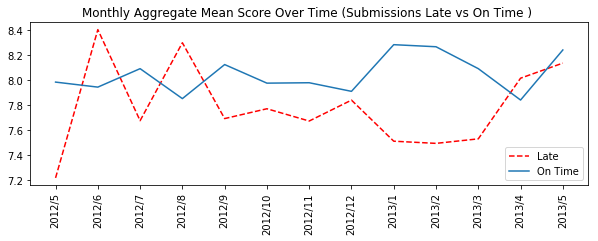

In [289]:
month_means_late=merged_data[merged_data.submitted_late==1].reset_index(drop=True).groupby(['month','group'])['updated_score'].agg('mean').reset_index()
month_means_late2=month_means_late.groupby(['month'])['updated_score'].agg('mean').reset_index()
month_means_late2=month_means_late2.sort_values(by='month', ascending=True)

month_means_not_late=merged_data[merged_data.submitted_late==0].reset_index(drop=True).groupby(['month','group'])['updated_score'].agg('mean').reset_index()
month_means_not_late2=month_means_not_late.groupby(['month'])['updated_score'].agg('mean').reset_index()
month_means_not_late2=month_means_not_late2.sort_values(by='month', ascending=True)
plt.figure(figsize=(10,3))
plt.plot (range(len(month_means_late2.updated_score)),month_means_late2.updated_score, color='r', linestyle='dashed')
plt.plot (range(len(month_means_late2.updated_score)),month_means_not_late2.updated_score)

plt.xticks(range(len(month_means_late2.updated_score)),['2012/5', '2012/6', '2012/7', '2012/8', '2012/9', '2012/10',
       '2012/11', '2012/12', '2013/1', '2013/2', '2013/3', '2013/4',
       '2013/5'], rotation='vertical')
plt.title('Monthly Aggregate Mean Score Over Time (Submissions Late vs On Time ) ')
plt.legend(['Late', 'On Time'])
plt.show()


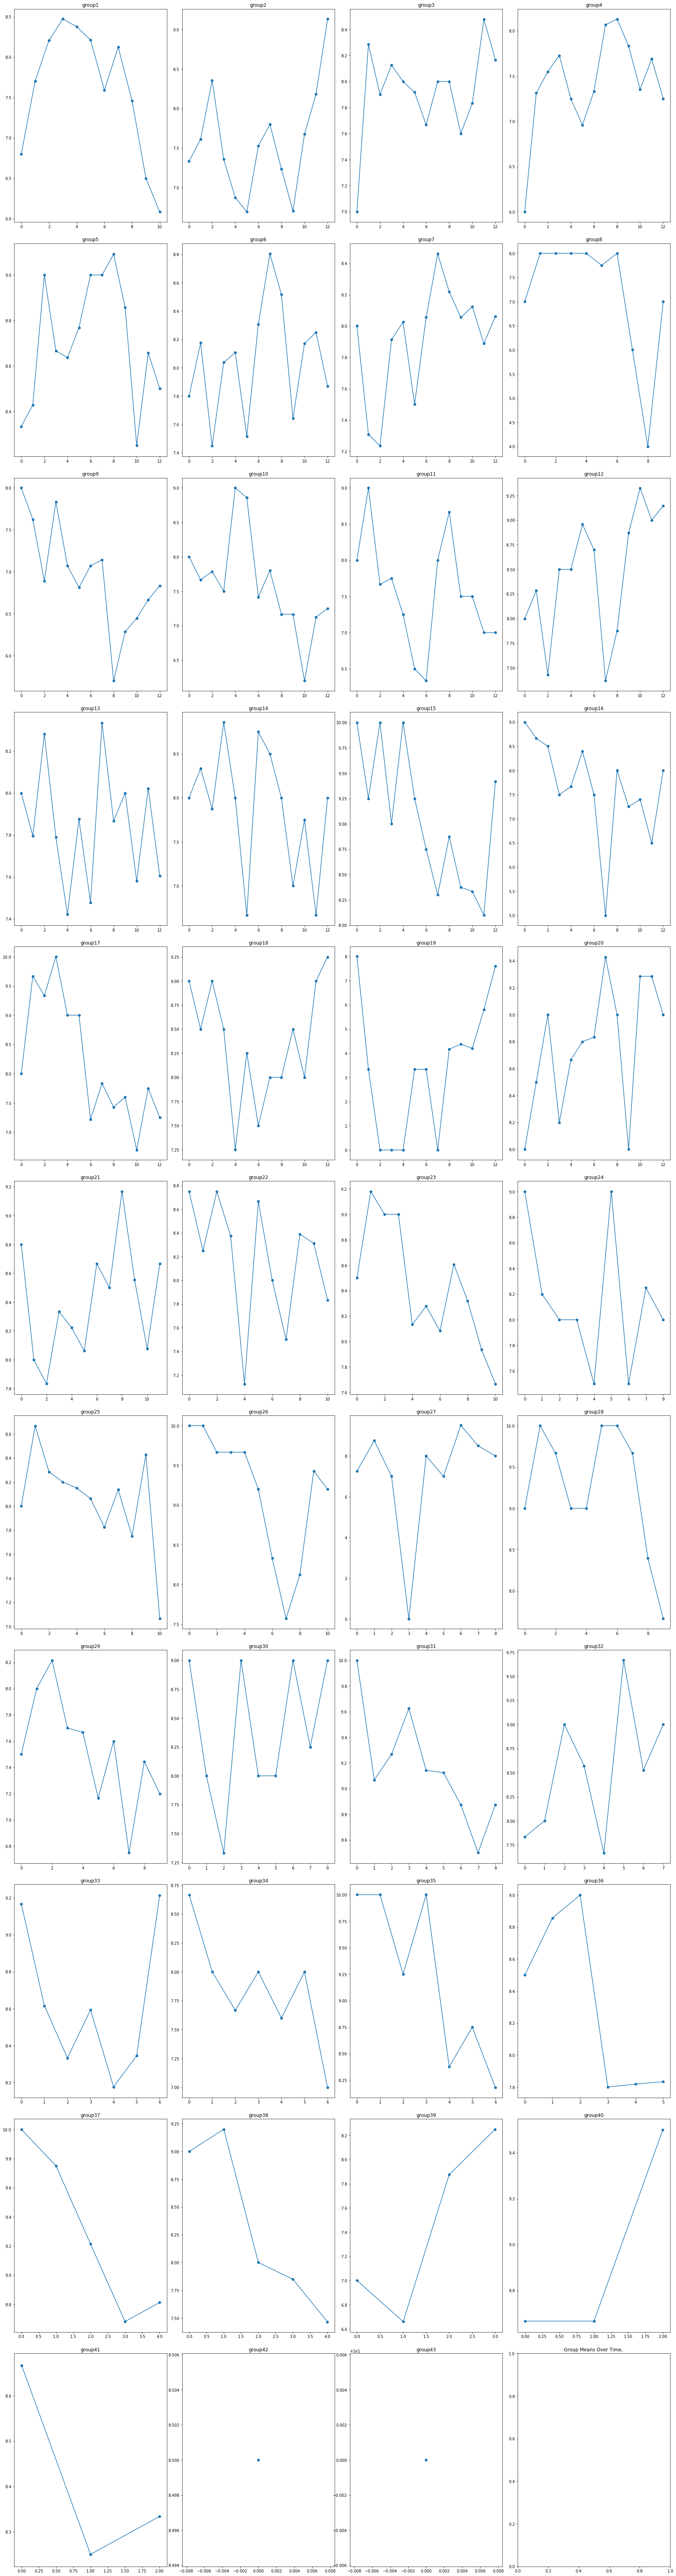

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
fig, axs = plt.subplots(11,4, figsize=(30, 120), facecolor='w', edgecolor='k', sharex=False, sharey=False)
fig.subplots_adjust(hspace = .1, wspace=.1)

axs = axs.ravel()

counter=0
for grp in merged_data.group.unique():
    x=monthly_group[monthly_group.group==grp]
    x=x.sort_values(by='month', ascending=True)
    axs[counter].scatter(range(len(x)), x.updated_score)
    axs[counter].plot(range(len(x)), x.updated_score)
    axs[counter].set_title(grp)
    counter+=1

plt.title('Group Means Over Time, ')
plt.show()

LOOK AT SUBMITTED LATE

We first check the means:

In [82]:
merged_data.updated_score[merged_data.submitted_late==1].mean()

7.7735676304347825

In [83]:
merged_data.updated_score[merged_data.submitted_late==0].mean()

8.170923821039903

Means are different, we employ a t-test to check if the means are significantly different

In [84]:
stats.ttest_ind(merged_data.updated_score[merged_data.submitted_late==0],
                merged_data.updated_score[merged_data.submitted_late==1], equal_var = False)

Ttest_indResult(statistic=7.079736950794968, pvalue=1.8296412262578244e-12)

p value less than 0.05 indicates that means are different, which suggests late submissions can be used as a signal

Check if there are certain groups where majority of employees submit late

In [85]:
late_grps=merged_data.groupby(['group','submitted_late']).agg('count').reset_index()[['group','submitted_late', 'employee']]

In [86]:
xx=late_grps.pivot(index='group', columns='submitted_late', values='employee').reset_index().sort_values(by='group', ascending=True)
xx.columns=[ 'group', 'on_time', 'late']

In [87]:
xx['late_ratio']=100*xx.late/xx.on_time

How do employee happinesss change over time?
group effect--> can consider all individual groups or cluster of groups
late submission --> how does it change the relation
month effect --> how does it change the relation

In [88]:
merged_data.head()

,employee,group,submit_date,review_date,submitted_late,employee_score,group_score,updated_score,month,day
0,employee1,group1,2012-05-24 17:11:00,5/25/12 15:47,0,7.0,8.0,7.0,2012/05,2012/05/24
1,employee2,group2,2012-05-24 17:47:00,5/25/12 13:49,0,9.0,8.0,9.0,2012/05,2012/05/24
2,employee3,group2,2012-05-24 17:54:00,5/25/12 13:48,0,7.0,8.0,7.0,2012/05,2012/05/24
3,employee4,group3,2012-05-24 18:13:00,5/26/12 08:52,0,8910.0,8.0,8.0,2012/05,2012/05/24
4,employee5,group4,2012-05-24 19:04:00,5/25/12 14:08,0,7.0,8.0,7.0,2012/05,2012/05/24


In [89]:
merged_data.month.unique()

array(['2012/05', '2012/06', '2012/07', '2012/08', '2012/09', '2012/10',
       '2012/11', '2012/12', '2013/01', '2013/02', '2013/03', '2013/04',
       '2013/05'], dtype=object)

In [90]:
equiv = {'2012/5':1, '2012/6':2, '2012/7':3, '2012/8':4, '2012/9':5, '2012/10':6,
       '2012/11':7, '2012/12':8, '2013/1':9, '2013/2':10, '2013/3':11, '2013/4':12,
       '2013/5':13}
merged_data["time"] = merged_data["month"].map(equiv)

In [91]:
merged_data.tail()

,employee,group,submit_date,review_date,submitted_late,employee_score,group_score,updated_score,month,day,time
3856,employee162,group35,2013-05-13 22:29:00,0000-00-00 00:00:00,1,8.0,10.0,8.0,2013/05,2013/05/13,NaN
3857,employee159,group42,2013-05-10 09:31:00,5/10/13 13:28,0,8.0,8.0,8.0,2013/05,2013/05/10,NaN
3858,employee160,group15,2013-05-11 11:25:00,0000-00-00 00:00:00,0,10.0,10.0,10.0,2013/05,2013/05/11,NaN
3859,employee161,group43,2013-05-12 10:30:00,0000-00-00 00:00:00,1,10.0,10.0,10.0,2013/05,2013/05/12,NaN
3860,employee162,group35,2013-05-13 22:29:00,0000-00-00 00:00:00,1,8.0,10.0,8.0,2013/05,2013/05/13,NaN


In [92]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


md = smf.mixedlm("updated_score ~ 1", merged_data, groups=merged_data[["group", 'month']])

mdf = md.fit()
print(mdf.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: updated_score
No. Observations: 3861    Method:             REML         
No. Groups:       2       Scale:              0.0000       
Min. group size:  1       Likelihood:         55311.7497   
Max. group size:  1       Converged:          Yes          
Mean group size:  1.0                                      
------------------------------------------------------------
             Coef.  Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    8.000     0.016  497.031  0.000   7.968   8.032
groups RE    0.001    81.762                                



/anaconda3/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Create indicator for late submission ratio in groups


In [118]:
merged_data.head()

,employee,group,submit_date,review_date,submitted_late,employee_score,group_score,updated_score,month,day,time
0,employee1,group1,2012-05-24 17:11:00,5/25/12 15:47,0,7.0,8.0,7.0,2012/05,2012/05/24,NaN
1,employee2,group2,2012-05-24 17:47:00,5/25/12 13:49,0,9.0,8.0,9.0,2012/05,2012/05/24,NaN
2,employee3,group2,2012-05-24 17:54:00,5/25/12 13:48,0,7.0,8.0,7.0,2012/05,2012/05/24,NaN
3,employee4,group3,2012-05-24 18:13:00,5/26/12 08:52,0,8910.0,8.0,8.0,2012/05,2012/05/24,NaN
4,employee5,group4,2012-05-24 19:04:00,5/25/12 14:08,0,7.0,8.0,7.0,2012/05,2012/05/24,NaN


In [230]:
late_prc=merged_data.groupby(['group']).agg({'updated_score':'mean', 'submitted_late' :"sum","group_score":"count"}).\
            reset_index()
    
late_prc.columns=['group' ,'updated_score' ,'submitted_late', 'total']
late_prc['late_percent']=late_prc.submitted_late.div(late_prc.total)
late_prc.late_percent.describe()

count    43.000000
mean      0.322219
std       0.207075
min       0.000000
25%       0.172118
50%       0.323009
75%       0.462500
max       1.000000
Name: late_percent, dtype: float64

In [171]:
late_prc.group=late_prc.group.apply(lambda x: int(x.split('group')[1]))

In [130]:
late_prc['late']= np.where(late_prc['late_percent']>=0.462500, 1, 0)

In [172]:
late_prc.head()

,group,updated_score,submitted_late,total,late_percent,late
0,1,7.920851,95,235,0.404255,0
1,10,7.550000,37,70,0.528571,1
2,11,7.512821,0,39,0.000000,0
3,12,8.630374,38,214,0.177570,0
4,13,7.801327,73,226,0.323009,0


In [180]:
late_prc=late_prc.sort_values(by='group', ascending=True).reset_index(drop=True)
late_prc.head()

,group,updated_score,submitted_late,total,late_percent,late
0,1,7.920851,95,235,0.404255,0
1,2,7.600610,65,164,0.396341,0
2,3,8.005650,96,177,0.542373,1
3,4,7.548458,99,227,0.436123,0
4,5,8.705873,27,139,0.194245,0


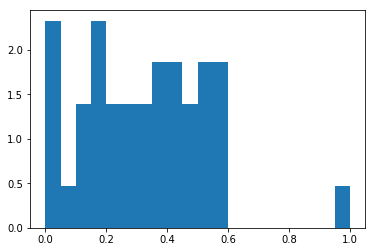

In [181]:
plt.hist(late_prc.late_percent, bins=20, normed=True)
plt.show()

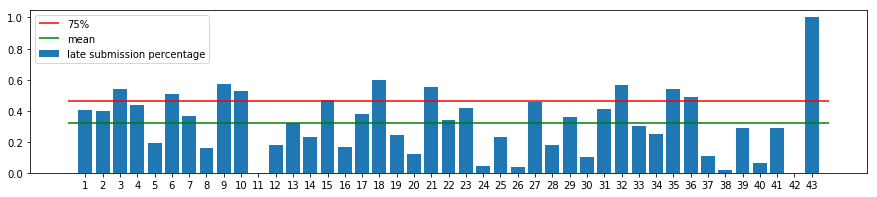

In [210]:
plt.figure(figsize=(15,3))
plt.bar(late_prc.group, late_prc.late_percent)
plt.xticks(late_prc.group)
plt.hlines(y=0.462500, color='r', xmin=0, xmax=44)
plt.hlines(y=0.323009, color='g', xmin=0, xmax=44)
plt.legend([ '75%', 'mean', 'late submission percentage'])
plt.show()

In [138]:
monthly_group=merged_data.groupby(['group', 'month']).agg({'updated_score':'mean'}).reset_index()

monthly_group.head()

,group,month,updated_score
0,group1,2012/05,6.800000
1,group1,2012/06,7.704545
2,group1,2012/07,8.208333
3,group1,2012/08,8.472727
4,group1,2012/09,8.376667


In [245]:

late_month=merged_data.groupby(['group','month']).agg({'updated_score':'mean', 'submitted_late' :"sum","group_score":"count"}).\
            reset_index()
    
late_month.columns=['group','month' ,'updated_score' ,'submitted_late', 'total']
late_month['late_percent']=late_month.submitted_late.div(late_month.total)




In [270]:
merged_month=pd.merge(left=monthly_group, right=late_month, left_on='group', right_on='group', how='left')
merged_month['late']= np.where(merged_month['late_percent']>=0.462500, 1, 0)
merged_month=merged_month[['group', 'month_x', 'updated_score_x', 'late']]
merged_month.columns=['group', 'month', 'updated_score', 'late']
grp_late=merged_month[merged_month.late==1].groupby('month').agg('mean').reset_index()
grp_on_time=merged_month[merged_month.late==0].groupby('month').agg('mean').reset_index()


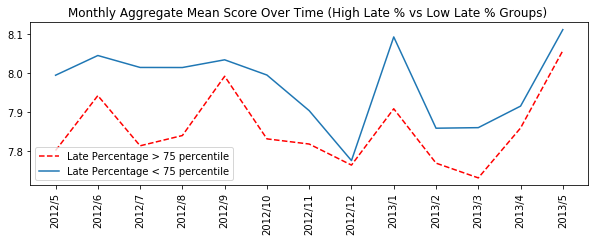

In [285]:

plt.figure(figsize=(10,3))
plt.plot (range(len(grp_late.updated_score)),grp_late.updated_score, color='r', linestyle='dashed')
plt.plot (range(len(grp_on_time.updated_score)),grp_on_time.updated_score)
plt.xticks(range(len(grp_late)),['2012/5', '2012/6', '2012/7', '2012/8', '2012/9', '2012/10',
       '2012/11', '2012/12', '2013/1', '2013/2', '2013/3', '2013/4',
       '2013/5'], rotation='vertical')
plt.title('Monthly Aggregate Mean Score Over Time (High Late % vs Low Late % Groups) ')
plt.legend(['Late Percentage > 75 percentile', 'Late Percentage < 75 percentile'])

plt.show()

Late submissions per employee:

In [205]:
late_emp=merged_data.groupby(['employee']).agg({'updated_score':'mean', 'submitted_late' :"sum","group_score":"count"}).\
            reset_index()
    
late_emp.columns=['employee' ,'updated_score' ,'submitted_late', 'total']
late_emp['late_percent']=late_emp.submitted_late.div(late_emp.total)
late_emp.late_percent.describe()

count    162.000000
mean       0.344339
std        0.277657
min        0.000000
25%        0.111111
50%        0.290278
75%        0.552825
max        1.000000
Name: late_percent, dtype: float64

In [204]:
merged_data.head()

,employee,group,submit_date,review_date,submitted_late,employee_score,group_score,updated_score,month,day,time
0,employee1,group1,2012-05-24 17:11:00,5/25/12 15:47,0,7.0,8.0,7.0,2012/05,2012/05/24,NaN
1,employee2,group2,2012-05-24 17:47:00,5/25/12 13:49,0,9.0,8.0,9.0,2012/05,2012/05/24,NaN
2,employee3,group2,2012-05-24 17:54:00,5/25/12 13:48,0,7.0,8.0,7.0,2012/05,2012/05/24,NaN
3,employee4,group3,2012-05-24 18:13:00,5/26/12 08:52,0,8910.0,8.0,8.0,2012/05,2012/05/24,NaN
4,employee5,group4,2012-05-24 19:04:00,5/25/12 14:08,0,7.0,8.0,7.0,2012/05,2012/05/24,NaN


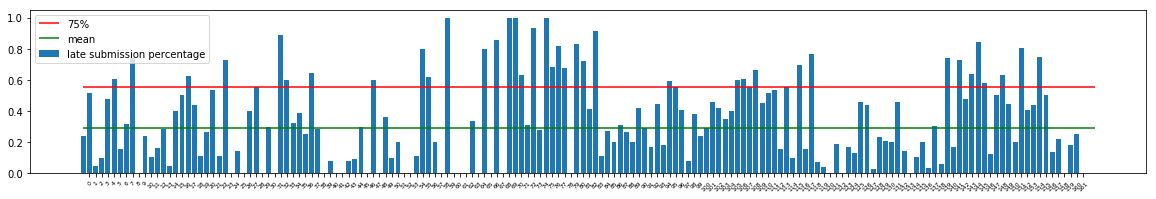

In [223]:
plt.figure(figsize=(20,3))
plt.bar(late_emp.employee, late_emp.late_percent)
plt.xticks((np.arange(len(late_emp.employee))+1),np.arange(len(late_emp.employee)), fontsize=6, rotation=45)
plt.hlines(y=0.552825, color='r', xmin=0, xmax=164)
plt.hlines(y=0.290278, color='g', xmin=0, xmax=164)
plt.legend([ '75%', 'mean', 'late submission percentage'])
plt.show()